<a href="https://colab.research.google.com/github/anniebritton/Ecological-Drought-ML-Modeling/blob/main/NDVI_Additional_Research_Questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workbook Setup**

In [ ]:
# install and import libraries
!pip install lazypredict
!pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit Learn
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Other Tools
import lazypredict
from lazypredict.Supervised import LazyRegressor
import shap
from joblib import dump, load

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# **Import Data**

In [ ]:
# Load in and configure the data
normalized_df = pd.read_csv('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/CSVs/NDVI_clean_preprocessed_longtermdrought_swe.csv', index_col=[0])
normalized_df['date'] = pd.to_datetime(normalized_df['date'])
normalized_df = normalized_df.set_index('date')

# Get column names that end with "_anomaly_roll"
columns_to_rename = [col for col in normalized_df.columns if col.endswith('_anomaly_roll')]

# Create a mapping of old column names to new column names
rename_dict = {col: col[:-len('_anomaly_roll')].upper() for col in columns_to_rename}

# Rename columns in the DataFrame and capitalize column names
normalized_df.rename(columns=rename_dict, inplace=True)
normalized_df.rename(columns={'TMIN': 'Tmin', 'TMAX': 'Tmax', 'PRECIP': 'Precip', 'PALMERZ': 'PalmerZ',}, inplace=True)

# Check the df's columns
normalized_df.columns

In [ ]:
# Select the columns based V1 model results
normalized_df = normalized_df[['NDVI', 'PDSI', 'PalmerZ',  'SWE', 'EDDI1Y', 
                               'EDDI5Y', 'SPEI270', 'SPEI1Y', 'SPEI2Y', 'SPEI5Y', 
                               'SPI90', 'SPI180', 'SPI270', 'SPI1Y', 'SPI2Y', 'SPI5Y', ]]
normalized_df

# **Train Test Split**

In [ ]:
# Based on our results above, select the last 20% of the data to be our test set
# Define our x and y variables
X = normalized_df.iloc[:, 1:].values
y = normalized_df.iloc[:, 0].values.ravel()

# Split up the test and training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data shape - x_train: ", x_train.shape)
print("Training data shape - y_train: ", y_train.shape)
print("Testing data shape - x_test: ", x_test.shape)
print("Testing data shape - y_test: ", y_test.shape)

Training data shape - x_train:  (1272, 15)
Training data shape - y_train:  (1272,)
Testing data shape - x_test:  (318, 15)
Testing data shape - y_test:  (318,)


#**Baseline Model**

In [ ]:
# Define your model
xgb_model = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=False)#, random_state=42)

# Run k-fold cross validation on the model
results = cross_val_score(xgb_model, x_train, y_train, cv=kfold, scoring='r2')

# Fit the model to the training data
xgb_model.fit(x_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = xgb_model.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the cross validation and test results
print("Cross Val Results:", results)
print("Cross Val Mean Result:", results.mean())

print('Test Mean Squared Error:', mse)
print('Test Root Mean Squared Error:', rmse)
print('Test R-squared:', r2)

Cross Val Results: [0.36987777 0.44168307 0.11857321 0.05824588 0.0840482 ]
Cross Val Mean Result: 0.21448562369480717
Test Mean Squared Error: 0.5967934459565569
Test Root Mean Squared Error: 0.7725240746776484
Test R-squared: 0.42674420016364256


#**Hyperparameter Optimization** - Random Search

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': uniform(0.01, 1),
    'max_depth': randint(0, 15),
    'min_child_weight': randint(0, 25),
    'subsample': uniform(0.01, 1),
    'colsample_bytree': uniform(0.01, 1),
    'n_estimators': randint(1, 2000)
}

# Define the regression model
xgb = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=False)

# Define the random search object
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=kfold, n_iter=100, random_state=42, verbose=3)

# Fit the random search to the training data
random_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)
print("R2 Score: ", r2)

#**Hyperparameter Optimization** - Grid Search

In [ ]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': [0.3],
    'max_depth': [6],
    'min_child_weight': [1],
    'subsample': [1],
    'colsample_bytree': [1],
    'n_estimators': [372, 373, 374]
}

# Define the regression model
xgb = XGBRegressor(objective='reg:squarederror')

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 42)

# Define the search object
grid_search = GridSearchCV(xgb, param_dist, cv=kfold, verbose = 3)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

# Predict the test data using the best trained model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("R2 Score: ", r2)

# **Tuning Results**

In [ ]:
# Best hyperparameters: colsample_bytree = 1, learning_rate = 0.3, max_depth = 6, min_child_weight = 1, n_estimators = 373, subsample = 1
# Best Test score: 0.4349336213612607

# **Train and Test**

In [ ]:
# Define our x and y variables
X = normalized_df.iloc[:, 1:].values
y = normalized_df.iloc[:, 0].values.ravel()

# Split up the test and training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data shape - x_train: ", x_train.shape)
print("Training data shape - y_train: ", y_train.shape)
print("Testing data shape - x_test: ", x_test.shape)
print("Testing data shape - y_test: ", y_test.shape)

Training data shape - x_train:  (1272, 15)
Training data shape - y_train:  (1272,)
Testing data shape - x_test:  (318, 15)
Testing data shape - y_test:  (318,)


In [ ]:
# # XGBoost
# # Define the model based on the best parameters
# xg_reg = XGBRegressor(colsample_bytree = 1,
#                       learning_rate = 0.3,
#                       max_depth = 6,
#                       min_child_weight = 1,
#                       n_estimators = 373,
#                       subsample = 1)

# # Fit the model to the training data
# xg_reg.fit(x_train, y_train)

# # Save the model for reproducibility
# dump(xg_reg, '/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/xgb_reg_v2.joblib') 

In [ ]:
# Load the model
xg_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/xgb_reg_v2.joblib') 

# Use the trained model to make predictions on the test data
xg_y_pred = xg_reg.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, xg_y_pred )
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xg_y_pred )

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Squared Error: 0.5882677705106018
Root Mean Squared Error: 0.7669861605730587
R-squared: 0.4349336213612607


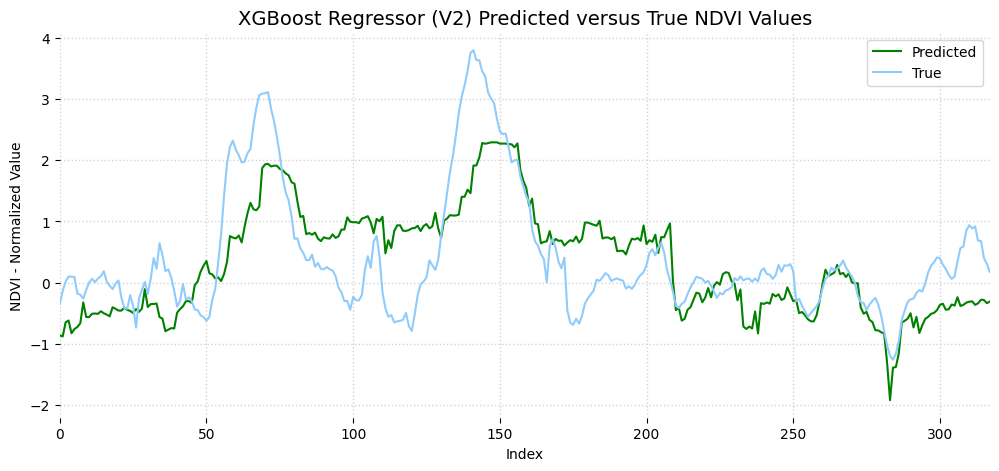

In [ ]:
# Set figure size
plt.figure(figsize=(12, 5))

# Plot the predicted values  in blue
plt.plot(xg_y_pred, label='Predicted', color='green')

# Plot the true values (`y_test`) in red
plt.plot(y_test, label='True', color='#8fccfb')

# Set x-axis limit to start and stop with the data
plt.xlim(0, len(xg_y_pred)-1)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('NDVI - Normalized Value')
plt.title("XGBoost Regressor (V2) Predicted versus True NDVI Values", fontsize=14)
plt.legend()

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Show the plot
plt.show()

# **Feature Importance**

Feature Importance Ranking:
SPEI1Y : 0.2183447
PDSI : 0.13778879
SPEI2Y : 0.096833244
SPI90 : 0.08239139
SPI5Y : 0.077548414
SWE : 0.0751985
SPI180 : 0.05310761
SPEI5Y : 0.04407232
SPEI270 : 0.042199783
SPI270 : 0.03730934
PalmerZ : 0.036828194
SPI1Y : 0.035104003
EDDI1Y : 0.023073798
EDDI5Y : 0.022962373
SPI2Y : 0.01723742


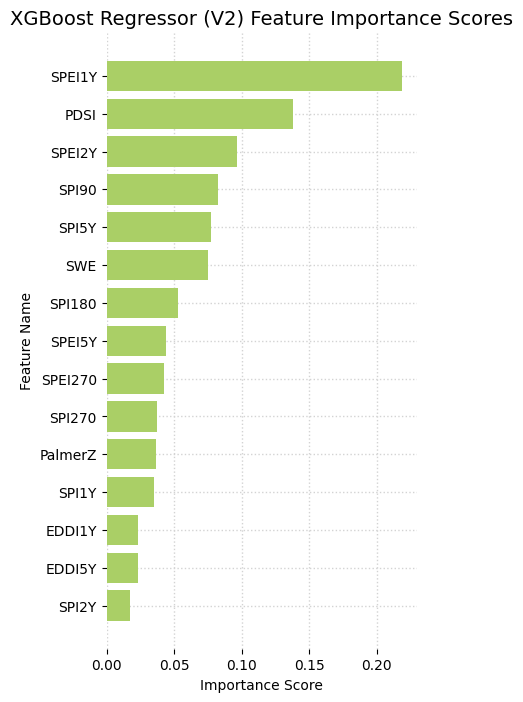

In [ ]:
# XGB
# Get feature importance scores
importance = xg_reg.feature_importances_

# Create a list of feature names
features = list(normalized_df.columns[1:16])

# Create a dictionary of feature importance scores and feature names
feature_importance = dict(zip(features, importance))

# Sort the dictionary by feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance ranking
print("Feature Importance Ranking:")
for feature, importance_score in sorted_feature_importance:
    print(feature, ":", importance_score)

# Create a list of feature names and importance scores, in reverse order
features = [x[0] for x in reversed(sorted_feature_importance)]
importance_scores = [x[1] for x in reversed(sorted_feature_importance)]

# Set the desired style
plt.style.use('default')

# Set figure size
plt.figure(figsize=(4, 8))

# Create a horizontal bar chart
plt.barh(features, importance_scores, color='#aacf66')

# Add a title and axis labels
plt.title('XGBoost Regressor (V2) Feature Importance Scores', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Display the chart
plt.show()

# **XAI**

In [ ]:
#create a feature name variable that should match the below
feature_names = ['PDSI', 'Palmer Z', 'SWE', 'EDDI 1-Year','EDDI 5-Year', 'SPEI 270-Day',
       'SPEI 1-Year', 'SPEI 2-Year', 'SPEI 5-Year', 'SPI 90-Day', 'SPI 180-Day', 'SPI 270-Day', 'SPI 1-Year',
       'SPI 2-Year', 'SPI 5-Year']

normalized_df.columns[1:]

Index(['PDSI', 'PalmerZ', 'SWE', 'EDDI1Y', 'EDDI5Y', 'SPEI270', 'SPEI1Y',
       'SPEI2Y', 'SPEI5Y', 'SPI90', 'SPI180', 'SPI270', 'SPI1Y', 'SPI2Y',
       'SPI5Y'],
      dtype='object')

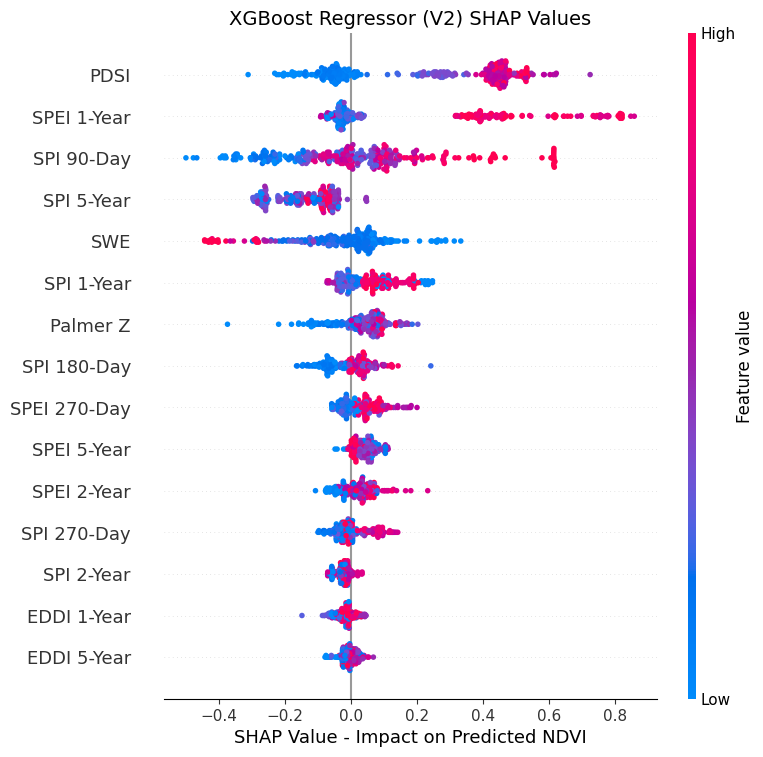

In [ ]:
# Load the model
xg_reg = load('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Models/xgb_reg_v2.joblib') 

# Use the model to make predictions
xg_y_pred = xg_reg.predict(x_test)

# Explain results using SHAP
xg_explainer = shap.Explainer(xg_reg)
xg_shap_values = xg_explainer(x_test)

# Summary plot with custom colors
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names, show=False)
plt.title("XGBoost Regressor (V2) SHAP Values", fontsize = 14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')
plt.show()

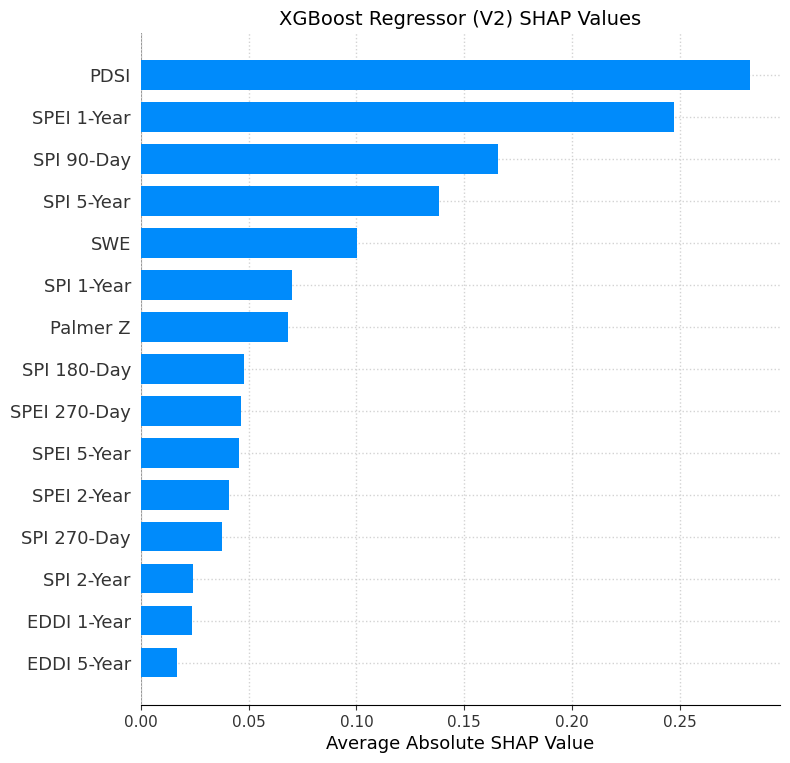

In [ ]:
# create a bar plot showing the above
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names, plot_type="bar", show=False)

plt.title("XGBoost Regressor (V2) SHAP Values", fontsize = 14)
plt.xlabel('Average Absolute SHAP Value')

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

plt.show()

In [ ]:
shap.initjs()
shap.force_plot(xg_explainer.expected_value, xg_shap_values.values, x_test, feature_names=feature_names)

Text(0.5, 0, 'SHAP Value - Impact on Predicted NDVI')

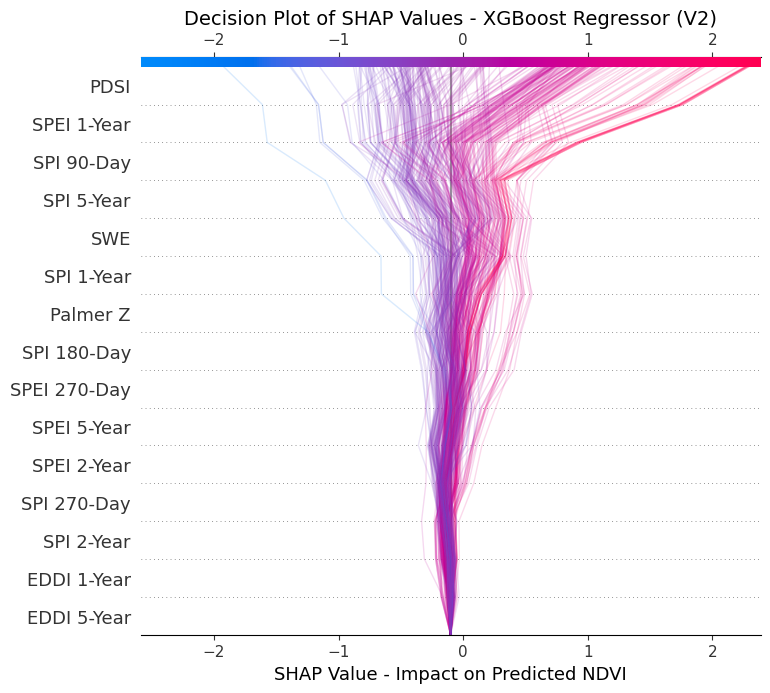

In [ ]:
shap.decision_plot(xg_explainer.expected_value, xg_shap_values.values, feature_names=feature_names, show=False, alpha=0.15)
plt.title("Decision Plot of SHAP Values - XGBoost Regressor (V2)", fontsize = 14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')